In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color, feature
from skimage.transform import rescale, resize, rotate, integral_image
from skimage.feature import haar_like_feature, haar_like_feature_coord, draw_haar_like_feature
from skimage.exposure import equalize_hist
from skimage.data import lfw_subset

from itertools import chain
from tqdm import tqdm
from random import sample
from time import time

from sklearn.feature_extraction.image import PatchExtractor
from sklearn.datasets import fetch_lfw_people
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from joblib import Parallel, delayed
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import datetime

from joblib import dump, load

## Preprocesamiento

In [63]:

lfw_people = fetch_lfw_people()
labels = lfw_people.target

new_resolution = (64, 64)  
#positive_patches = [resize(img, new_resolution, mode='reflect', anti_aliasing=True) for img in originalImages]
positive_patches = lfw_people.images
size = positive_patches[0].shape

imgs = ['camera',
        'text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    images.append(img)

    # Imagenes caseras adicionales
for i in range(16):
    filename = 'imagenes/'+str(i)+'.jpg'
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    images.append(img)

    
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=size):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    
    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    
    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])
    
    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])
    
    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 250, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.5, 0.75, 1.0, 1.5, 2.0]])
negative_patches.shape

X_train = np.array([feature.hog(im) for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X')])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1






Procesando imágenes: 100%|██████████| 26/26 [00:07<00:00,  3.27it/s]
Construyendo X: 45733it [00:35, 1282.60it/s]


In [66]:
# Dividir los datos en conjuntos de entrenamiento y prueba:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape

(36586, 1215)

##  Gradient Boosting

In [27]:
# HIPERPARAMETROS BAJOS PARA QUE NO TARDE TANTO
gb_classifier = GradientBoostingClassifier(n_estimators=5, learning_rate=0.1, random_state=0)
gb_classifier.fit(X_train, y_train)

y_pred = gb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
tnr = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'True Negative Rate (TNR): {tnr}')

Accuracy: 0.9201476588303866
Recall: 0.925981308411215
True Negative Rate (TNR): 0.9138349514563107


## Ada-Boost

In [19]:
# AdaBoost clasifier

# Bad clasifier
weak_classifier = DecisionTreeClassifier(max_depth=1)
# Good clasifier based in the bad one (for better results, increase the number of estimators)
adaboost_classifier = AdaBoostClassifier(base_estimator=weak_classifier, n_estimators=5, random_state=0)

adaboost_classifier.fit(X_train, y_train)

predictions = adaboost_classifier.predict(X_test)

# Focus on TNR (predict non-faces correctly)
y_pred = adaboost_classifier.predict(X_test)
y_true = y_test

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
conf_matrix = confusion_matrix(y_true, y_pred)
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
tnr = tn / (tn + fp)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'True Negative Rate (TNR): {tnr}')

Accuracy: 0.8943073635127259
Recall: 0.8691588785046729
True Negative Rate (TNR): 0.9215210355987055


In [20]:
# Added adaboost as a bagging base classifier
bagging_classifier = BaggingClassifier(adaboost_classifier, n_estimators=5, random_state=0)

bagging_classifier.fit(X_train, y_train)

y_pred = bagging_classifier.predict(X_test)
y_true = y_test

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

conf_matrix = confusion_matrix(y_true, y_pred)
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
tnr = tn / (tn + fp)

recall = recall_score(y_true, y_pred)

print(f'Recall: {recall}')
print(f'True Negative Rate (TNR): {tnr}')

Accuracy: 0.9174276277443171
Recall: 0.9151401869158878
True Negative Rate (TNR): 0.9199029126213593


## Random Forest

In [ ]:
# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=100, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])



## Regresión Logística

c:\Users\naist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\naist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

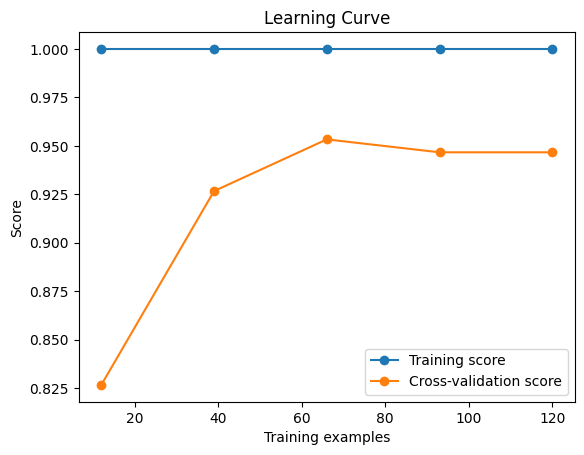

In [ ]:


clf = LogisticRegression(max_iter=500)
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=5)

plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

## Red Neuronal

In [104]:
#Crear red neuronal
def create_model():

 model = Sequential()
 model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
 model.add(Dropout(0.5))
 model.add(Dense(8, activation='relu'))
 model.add(Dropout(0.5))
 model.add(Dense(1, activation='sigmoid'))

 sgd = SGD(learning_rate=0.05, momentum=0.8)
 model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

 return model
 

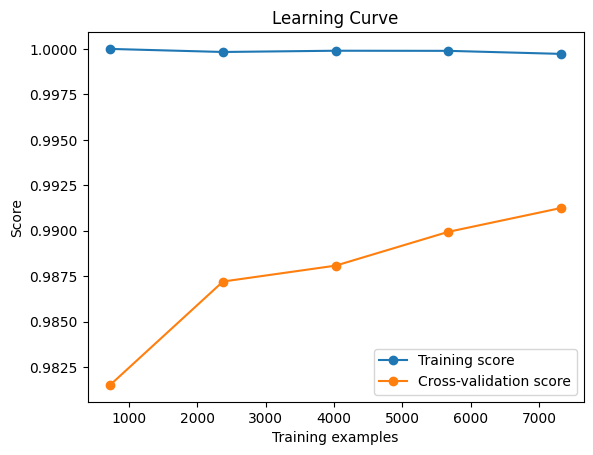

Recall: 0.9802731411229135
True Negative Rate (TNR): 0.9969282752265397


In [105]:

 
# Seed para poder reproducir el modelo
seed = 7
np.random.seed(seed)


model = KerasClassifier(model=create_model, epochs=150, batch_size=128, verbose=0)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.random import set_seed
import datetime
set_seed(1)
logdir = "logs/neuralNetwork/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [keras.callbacks.TensorBoard(log_dir=logdir), 
             keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]


#Entrenamiento
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=150, callbacks=callbacks)

y_pred = model.predict(X_test)


#Predicciones
train_sizes, train_scores, test_scores = learning_curve(model, X_test, y_pred, cv=5)

#Visualizar resultados
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
tnr = tn / (tn + fp)

recall = recall_score(y_test, y_pred)

print(f'Recall: {recall}')
print(f'True Negative Rate (TNR): {tnr}')


In [106]:
from joblib import dump, load

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

# Guardo Red Neuronal llamado 'model'
dump(model, 'modelo.joblib') 

# Para cargar el modelo en el futuro usar la función 'load'
# Se proporciona el nombre del archivo como argumento
model_saved = load('modelo.joblib') 

INFO:tensorflow:Assets written to: C:\Users\santi\AppData\Local\Temp\tmpiexu6pie\assets


INFO:tensorflow:Assets written to: C:\Users\santi\AppData\Local\Temp\tmpiexu6pie\assets


In [107]:
# Define una función para realizar una ventana deslizante (sliding window) sobre una imagen.
def sliding_window(img, 
                   patch_size=positive_patches[0].shape,  # Define el tamaño del parche (patch) basado en el primer parche positivo por defecto
                   istep=2,  # Paso de desplazamiento en la dirección i (verticalmente)
                   jstep=2,  # Paso de desplazamiento en la dirección j (horizontalmente)
                   scale=1.0):  # Factor de escala para ajustar el tamaño del parche
                   
    # Calcula las dimensiones Ni y Nj del parche ajustadas por el factor de escala.
    Ni, Nj = (int(scale * s) for s in patch_size)
    
    # Itera a lo largo de la imagen en la dirección i
    for i in range(0, img.shape[0] - Ni, istep):
        # Itera a lo largo de la imagen en la dirección j
        for j in range(0, img.shape[1] - Ni, jstep):
            
            # Extrae el parche de la imagen usando las coordenadas actuales i, j.
            patch = img[i:i + Ni, j:j + Nj]
            
            # Si el factor de escala es diferente de 1, redimensiona el parche al tamaño original del parche.
            if scale != 1:
                patch = resize(patch, patch_size)
            
            # Usa yield para devolver las coordenadas actuales y el parche. 
            # Esto convierte la función en un generador.
            yield (i, j), patch


def non_max_suppression(indices, Ni, Nj, overlapThresh):
    # Si no hay rectángulos, regresar una lista vacía
    if len(indices) == 0:
        return []

    # Si las cajas son enteros, convertir a flotantes
    if indices.dtype.kind == "i":
        indices = indices.astype("float")

    # Inicializar la lista de índices seleccionados
    pick = []

    # Tomar las coordenadas de los cuadros
    x1 = np.array([indices[i,0] for i in range(indices.shape[0])])
    y1 = np.array([indices[i,1] for i in range(indices.shape[0])])
    x2 = np.array([indices[i,0]+Ni for i in range(indices.shape[0])])
    y2 = np.array([indices[i,1]+Nj for i in range(indices.shape[0])])

    # Calcula el área de los cuadros y ordena los cuadros
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # Mientras todavía hay índices en la lista de índices
    while len(idxs) > 0:
        # Toma el último índice de la lista y agrega el índice a la lista de seleccionados
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Encontrar las coordenadas (x, y) más grandes para el inicio de la caja y las coordenadas (x, y) más pequeñas para el final de la caja
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Calcula el ancho y alto de la caja
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Calcula la proporción de superposición
        overlap = (w * h) / area[idxs[:last]]

        # Elimina todos los índices del índice de lista que tienen una proporción de superposición mayor que el umbral proporcionado
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Devuelve solo las cajas seleccionadas
    return indices[pick].astype("int")

In [108]:
# Cargo imagen de prueba

test_image_path = "imagenes/1_Rostro.jpg"
test_image = plt.imread(test_image_path)
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image,0.25)
test_image.shape


(238, 358)

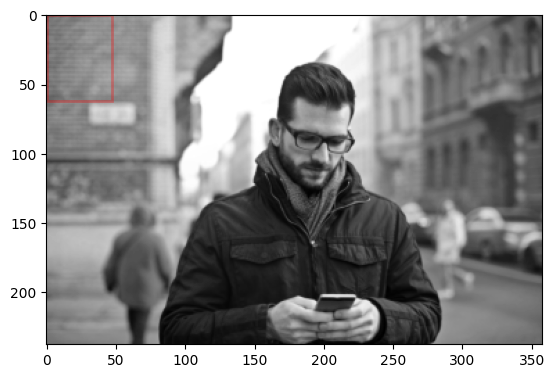

In [139]:
# Visualizamos la imagen
# Buscamos la escala de los rostros
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')

scale = 1
Ni, Nj = (int(scale * s) for s in positive_patches[0].shape)

ax.add_patch(plt.Rectangle((0, 0), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))
plt.show()

In [140]:
# Utiliza la función de ventana deslizante en una imagen de prueba.
# zip(*...) toma las tuplas generadas y las descompone en índices y parches.
indices, patches = zip(*sliding_window(test_image, scale=scale))

# Calcula las características HOG para cada parche y las almacena en un array.
patches_hog = np.array([feature.hog(patch) for patch in patches])

# Muestra la forma del array de características HOG.
patches_hog.shape


(13024, 1215)

In [143]:

# Cargo modelo de red neuronal:
model_saved = load('modelo.joblib') 
# Predicción
labels = model_saved.predict(patches_hog).astype(int)


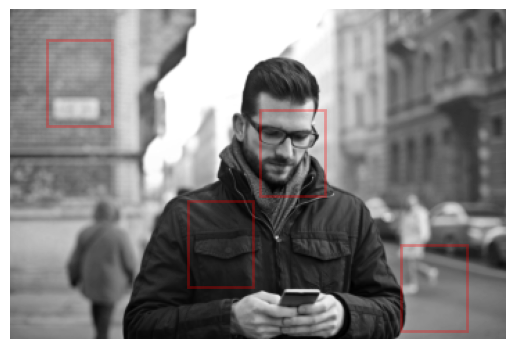

In [144]:
# Visualizamos las detecciones

Ni, Nj = (int(scale*s) for s in positive_patches[0].shape)
indices = np.array(indices)
detecciones = indices[labels == 1]
detecciones = non_max_suppression(np.array(detecciones),Ni,Nj, 0.1)

# Algoritmo que elimina las detecciones que se encuentran dentro de otras detecciones


# Visualizamos las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))